In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import librosa.display
import scipy

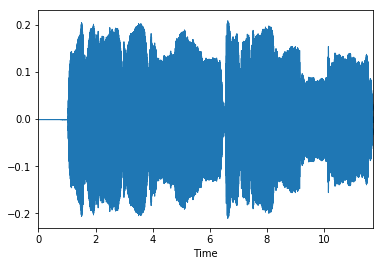

In [3]:
fname = 'happybirthdaytoyou_violin.wav'
x, sr = librosa.load(fname, sr=8000)
#x = x[:50000]
librosa.display.waveplot(x, sr=sr)

In [4]:
# get onset strength envelope
onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=np.median)
print(onset_env.shape)

(184L,)


D:\anaconda3\envs\new_nussl_env\lib\site-packages\librosa\filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


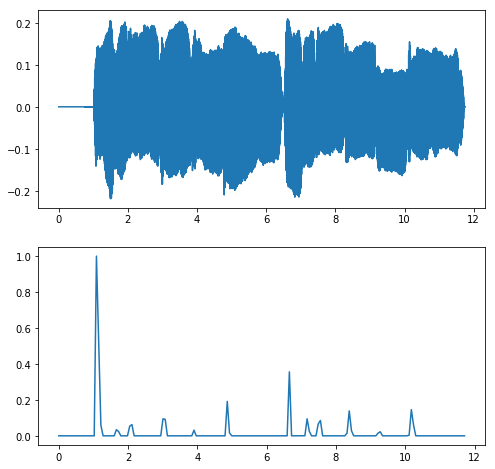

In [5]:
hop_length = 512
plt.figure(figsize=(8,8))
plt.subplot(211)
times = librosa.samples_to_time(np.arange(len(x)), sr=sr)
plt.plot(times, x)
plt.subplot(212)
times = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=hop_length)
plt.plot(times, librosa.util.normalize(onset_env), label='Onset strength')


#### Onset Strength Envelope
##### Step 1: calculate spectrogram (STFT)


In [6]:
win_length = 32 * sr // 1000
hop_length = 4 * sr // 1000
n_fft = 2048
y = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
Ay = np.abs(y)
y_mel = librosa.feature.melspectrogram(sr=sr, S=Ay**2, n_mels=40)
y_mel_dB = librosa.power_to_db(y_mel)

Text(0.5,1,'Mel spectrogram')

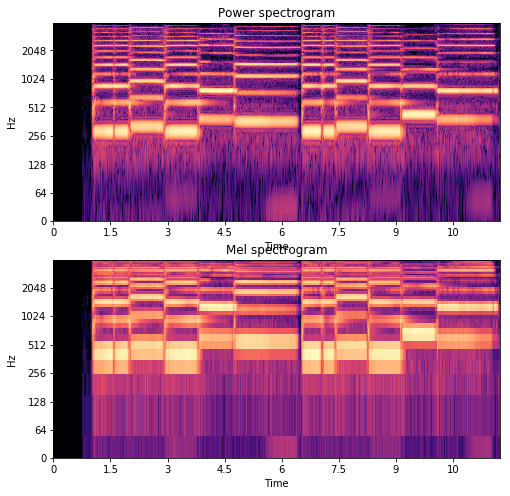

In [7]:
# plot spectrogram
times = librosa.frames_to_time(np.arange(Ay.shape[1]))
plt.figure(figsize=(8,8))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(Ay, ref=np.max), sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)
librosa.display.specshow(librosa.power_to_db(y_mel, ref=np.max), sr=sr, hop_length=hop_length, y_axis='log', x_axis='time')
plt.title('Mel spectrogram')

##### Step 2:  
2.1 first-order difference along time is calculated in each band 

2.2 Discard negatives (decreasing amplitude)

2.3 Aggregate within channels 



In [8]:
onset_env = y_mel_dB[:, 1:] - y_mel_dB[:, :-1]
onset_env = np.maximum(0.0, onset_env)
onset_env = librosa.util.sync(onset_env, [slice(None)], aggregate=np.median, pad=True,axis=0)
onset_env = onset_env[0,:]

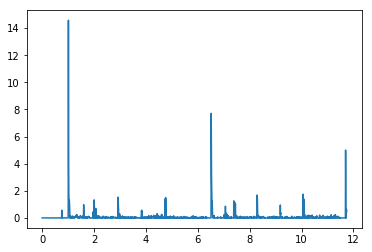

In [9]:
times = librosa.frames_to_time(np.arange(onset_env.shape[0]),sr=sr,hop_length=hop_length)
plt.plot(times, onset_env)

##### Step 3: post-process
3.1 compensate for lag 

3.2 remove the DC component 

3.3 trim to match the input duration 

3.4 normalize 

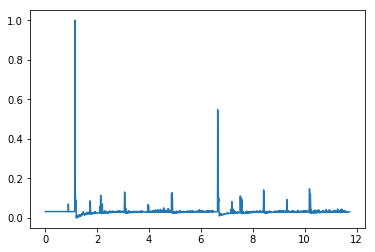

In [10]:
# compensate for lag
pad_width = 1
# Counter-act framing effects. Shift the onsets by n_fft / hop_length
pad_width += 2048 // (2 * hop_length)
onset_env = np.pad(onset_env, ([int(pad_width), 0]), mode='constant')

# remove the DC component
onset_env = scipy.signal.lfilter([1.0, -1.0], [1.0, -0.99], onset_env, axis=0)

# trim to match the input duration
onset_env = onset_env[:y_mel_dB.shape[1]]

# normalize
onset_env -= onset_env.min()
onset_env /= onset_env.max()

times = librosa.frames_to_time(np.arange(onset_env.shape[0]),sr=sr,hop_length=hop_length)
plt.plot(times, onset_env)

In [12]:
print(onset_env.shape)

(2935L,)


#### beat tracking by peak pick

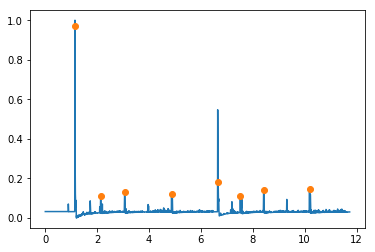

In [13]:
# peak pick
pre_max = 0.03 * sr // hop_length
post_max = 0.00 * sr // hop_length + 1
pre_avg = 0.10 * sr // hop_length
post_avg = 0.10 * sr // hop_length + 1
delta = 0.07
wait = 0.03 * sr // hop_length
onsets = librosa.util.peak_pick(onset_env[:], pre_max, post_max, pre_avg, post_avg, delta, wait)

plt.plot(times, onset_env)
plt.plot(times[onsets], onset_env[onsets], 'o')

#### Global Tempo Estimate
##### Step 1: autocorrelation

In [14]:
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)
ac = librosa.autocorrelate(onset_env, max_size=tempogram.shape[0])
ac = librosa.util.normalize(ac)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

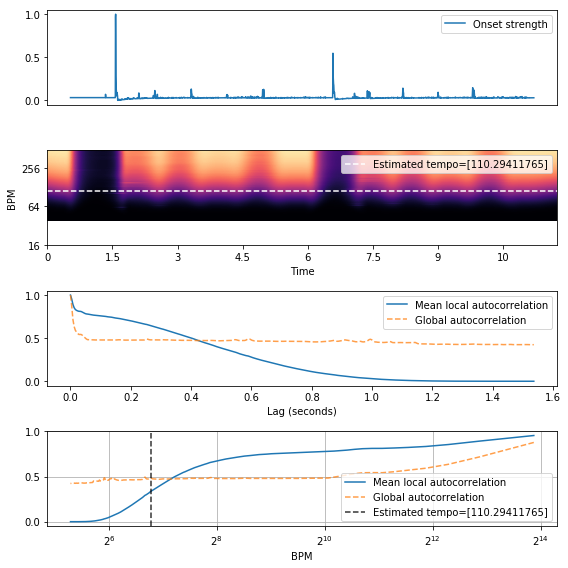

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(4, 1, 1)
plt.plot(onset_env, label="Onset strength")
plt.xticks([])
plt.legend(frameon=True)
plt.axis('tight')
plt.subplot(4, 1, 2)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='tempo')
plt.axhline(tempo, color='w', linestyle='--', alpha=1, 
            label='Estimated tempo={}'.format(tempo))
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(4, 1, 3)
xx = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
               num=tempogram.shape[0])
plt.plot(xx, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
plt.plot(xx, ac, '--', alpha=0.75, label='Global autocorrelation')
plt.xlabel('Lag (seconds)')
plt.axis('tight')
plt.legend(frameon=True)
plt.subplot(4, 1, 4)
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
plt.semilogx(freqs[1:], np.mean(tempogram[1:], axis=1), 
             label='Mean local autocorrelation', basex=2)
plt.semilogx(freqs[1:], ac[1:], '--', alpha=0.75,
            label='Global autocorrelation', basex=2)
plt.axvline(tempo, color='black', linestyle='--', alpha=.8,
           label='Estimated tempo={}'.format(tempo))
plt.legend(frameon=True)
plt.xlabel('BPM')
plt.axis('tight')
plt.grid()
plt.tight_layout()


##### step 2: aggregate

##### calculate with tempogram

In [179]:
start_bpm = 120
std_bpm = 1.0
tg = np.mean(tempogram, axis=1, keepdims=True)
bpms = librosa.tempo_frequencies(tg.shape[0], hop_length=hop_length, sr=sr)
prior = np.exp(-.05 * ((np.log2(bmps) - np.log2(start_bpm)) / std_bpm)**2)

# Weight the autocorrelation by a log-normal distribution
best_period = np.argmax(tg * prior[:, np.newaxis], axis=0)

tempi = bpms[best_period]
tempi[best_period == 0] = start_bpm
print(tempi)

# Weight the autocorrelation by a log-normal distribution
best_period_ac = np.argmax(ac * prior, axis=0)

tempi_ac = bpms[best_period_ac]
print(tempi_ac)

[128.20512821]
127.11864406779661


##### calculate with autocorrelation

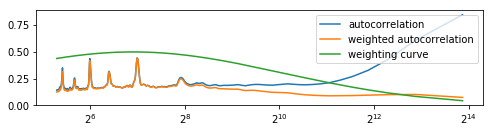

In [177]:
plt.figure(figsize=(8,8))
plt.subplot(4, 1, 1)
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)

plt.semilogx(freqs[:], ac[:], 
             label='autocorrelation', basex=2)
plt.semilogx(freqs[:], ac[:] * prior[:], 
             label='weighted autocorrelation', basex=2)
norm_prior = prior / prior.max()
plt.semilogx(freqs[:], norm_prior[:] * 0.5, 
             label='weighting curve', basex=2)


plt.legend(frameon=True)

#### Beat tracker system with Dynamic Programming
$$
C\left(\left\{t_{i}\right\}\right)=\sum_{i=1}^{N} O\left(t_{i}\right)+\alpha \sum_{i=2}^{N} F\left(t_{i}-t_{i-1}, \tau_{p}\right)
$$

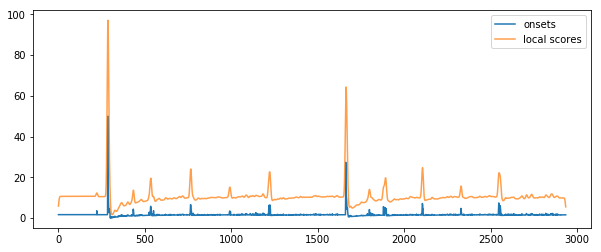

In [16]:
bpm = 110
fft_res = sr / hop_length
tightness = 100
onsets = onset_env.copy()

# convert bpm to a sample period for searching
period = round(60.0 * fft_res / bpm)

# localscore is a smoothed version of AGC'd onset envelope
norm = onsets.std(ddof=1)
if norm > 0:
    norm_onsets = onsets / norm
    
window = np.exp(-0.5 * (np.arange(-period, period+1)*32.0/period)**2)
localscore = scipy.signal.convolve(norm_onsets, window, 'same')

plt.figure(figsize=(10, 4))
plt.plot(onset_env * 50.0, label='onsets')
plt.plot(localscore, alpha=0.75, label='local scores')
plt.legend(frameon=True)


recursively calculate the best possible score
$$
C^{*}(t)=O(t)+\max _{\tau=0 \ldots t}\left\{\alpha F\left(t-\tau, \tau_{p}\right)+C^{*}(\tau)\right\}
$$

In [17]:
# run the DP
backlink = np.zeros_like(localscore, dtype=int)
cumscore = np.zeros_like(localscore)

# Search range for previous beat
window = np.arange(-2 * period, -np.round(period / 2) + 1, dtype=int)

# Make a score window, which begins biased toward start_bpm and skewed
txwt = -tightness * (np.log(-window / period)**2)

# Are we on the first beat?
first_beat = True
for i, score_i in enumerate(localscore):
    # Are we reaching back before time 0?
    z_pad = np.maximum(0, min(-window[0], len(window)))
    
    # Search over all possible predecessors
    candidates = txwt.copy()
    candidates[z_pad:] = candidates[z_pad:] + cumscore[window[z_pad:]]
    
    # Find the best preceding beat
    beat_location = np.argmax(candidates)
    
    # Add the local score
    cumscore[i] = score_i + candidates[beat_location]
    
    # Special case the first onset. Stop if the localscore is small
    if first_beat and score_i < 0.01 * localscore.max():
        backlink[i] = -1
    else:
        backlink[i] = window[beat_location]
        first_beat = False
        
    # Update the time range
    window = window + 1
    


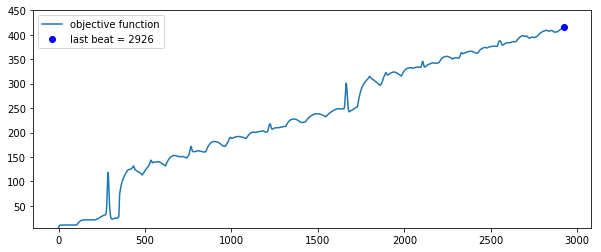

In [27]:
# get the last beat from the cumulative score array
maxes = librosa.util.localmax(cumscore)
med_score = np.median(cumscore[np.argwhere(maxes)])

# The last of these is the last beat (since score generally increses)
beats = np.argwhere((cumscore * maxes * 2 > med_score)).max()

plt.figure(figsize=(10, 4))
plt.plot(cumscore, label='objective function')
#plt.plot(cumscore * maxes, 'o', alpha= 0.6, label='local max')
#plt.axhline(med_score,  color='r', linestyle='--', alpha=1, 
#            label='median score = {}'.format(med_score))
#plt.plot(cumscore * (cumscore * maxes * 2 > med_score), 'r.', label='larger local max')
plt.plot(beats, cumscore[beats], 'bo', label='last beat = {}'.format(beats))
#plt.axvline(beats,  color='g', linestyle='--', alpha=1, 
#            label='last beat = {}'.format(beats))
plt.ylim(5, 450)

plt.legend(frameon=True)

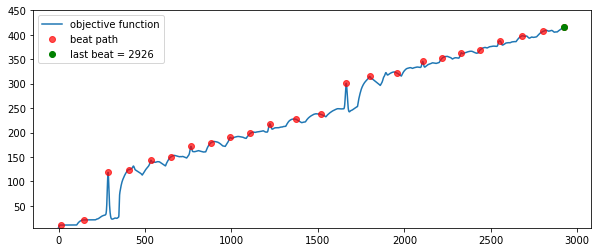

In [35]:
# Reconstruct the beat path from backlinks
beats_list = [beats]
while backlink[beats_list[-1]] >= 0:
    beats_list.append(backlink[beats_list[-1]])
    
beats_list = np.array(beats_list[::-1], dtype=int)

plt.figure(figsize=(10, 4))
plt.plot(cumscore, label='objective function')
plt.plot(beats_list, cumscore[beats_list], 'ro', alpha=0.7, label='beat path')
plt.plot(beats, cumscore[beats], 'go', label='last beat = {}'.format(beats))
#plt.plot(trim_beats, cumscore[trim_beats], 'go', label='trimmed beat')
plt.ylim(5, 450)
plt.legend(frameon=True)

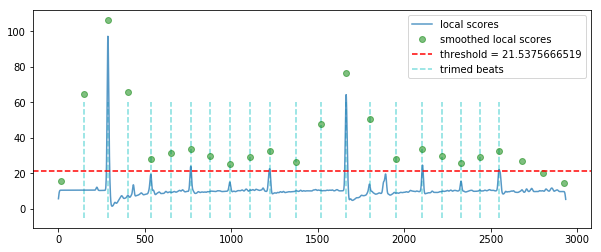

In [36]:
# Final post-processing: throw out spurious leading/trailing beats
smooth_boe = scipy.signal.convolve(localscore[beats_list], 
                                   scipy.signal.hann(5),
                                   'same')
threshold = 0.5 * ((smooth_boe**2).mean()**0.5)
valid = np.argwhere(smooth_boe > threshold)
trim_beats = beats_list[valid.min():valid.max()]

plt.figure(figsize=(10, 4))
plt.plot(localscore, alpha=0.75, label='local scores')
plt.plot(beats_list, smooth_boe, 'go',alpha=0.5, label='smoothed local scores')
plt.axhline(threshold, color='r', linestyle='--', alpha=1, 
            label='threshold = {}'.format(threshold))
plt.vlines(trim_beats, ymin=-5, ymax=60, color='c', linestyle='--', alpha=0.5, 
            label='trimed beats')
#plt.ylim(-5, 60)
plt.legend(frameon=True)